# Supervised modelling with R

In [ ]:
#install.packages("nloptr", lib="/opt/conda/lib/R/library")

In [2]:
#################################################################################################
######## the CARET package #########################################
#################################################################################################

# this tutorial has been inspired from:
# http://will-stanton.com/machine-learning-with-r-an-irresponsibly-fast-tutorial/
#install.packages("caret", lib="/opt/conda/lib/R/library", repo="http://cran.us.r-project.org")
install.packages("randomForest", lib="/opt/conda/lib/R/library", repo="http://cran.us.r-project.org")
install.packages("rpart", lib="/opt/conda/lib/R/library", repo="http://cran.us.r-project.org")
install.packages("rpart.plot", lib="/opt/conda/lib/R/library", repo="http://cran.us.r-project.org")
install.packages("ROCR", lib="/opt/conda/lib/R/library", repo="http://cran.us.r-project.org")
install.packages("foreach", lib="/opt/conda/lib/R/library", repo="http://cran.us.r-project.org")
install.packages("e1071", lib="/opt/conda/lib/R/library", repo="http://cran.us.r-project.org")
install.packages("doMC", lib="/opt/conda/lib/R/library", repo="http://cran.us.r-project.org")
#library(caret)
library(randomForest)
library(rpart)
library(rpart.plot)

library(e1071)
library(ROCR)
library(foreach)
library(doMC)
#setwd("~/Desktop/Lezione_22 Settembre_Modena/data/TITANIC")
rm(list=ls()) #clear workspace
set.seed(123) #set the seed

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
also installing the dependencies ‘codetools’, ‘iterators’

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
also installing the dependency ‘class’

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Loading required package: gplots

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess

Loading required package: iterators
Loading required package: parallel


### Data preparation

In [3]:

##########################################################################################
######### parallelization (it is the only instructions needed by CARET) ##################
##########################################################################################
#registerDoMC(10)

##########################################################################################
####################### load the data ####################################################
##########################################################################################
# we will use only the training set, since the test set is unlabelled
data=read.csv("data/TITANIC/train.csv",header=T,sep=",")

##########################################################################################
########### find and erase the rows that contain NAs #####################################
##########################################################################################
table(data$Embarked)
# it is the best way to keep things simple
data$Embarked[which(data$Embarked=="")]=NA
data=na.omit(data)

##########################################################################################
####### coerce a)Survived (1=yes, 0=no), b)Pclass and c)Embarked to factors ##############
##########################################################################################


data$Pclass=factor(data$Pclass)
data$Survived=factor(data$Survived)
data$Embarked=factor(data$Embarked)


      C   Q   S 
  2 168  77 644 

### Split the data into training/test sets

In [4]:
trainID=sample(nrow(data),nrow(data)*(4/5))
trainSet=data[trainID,-c(1,4,9,11)]
testSet=data[-trainID,-c(1,4,9,11)]
# some variables have been excluded!

### Which are the most "useful" variables?

   
             1          2          3
  0 0.08611599 0.13005272 0.37609842
  1 0.17398946 0.11599297 0.11775044

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.67   21.00   28.00   30.03   39.00   80.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    8.05   15.90   33.89   33.50  512.30 

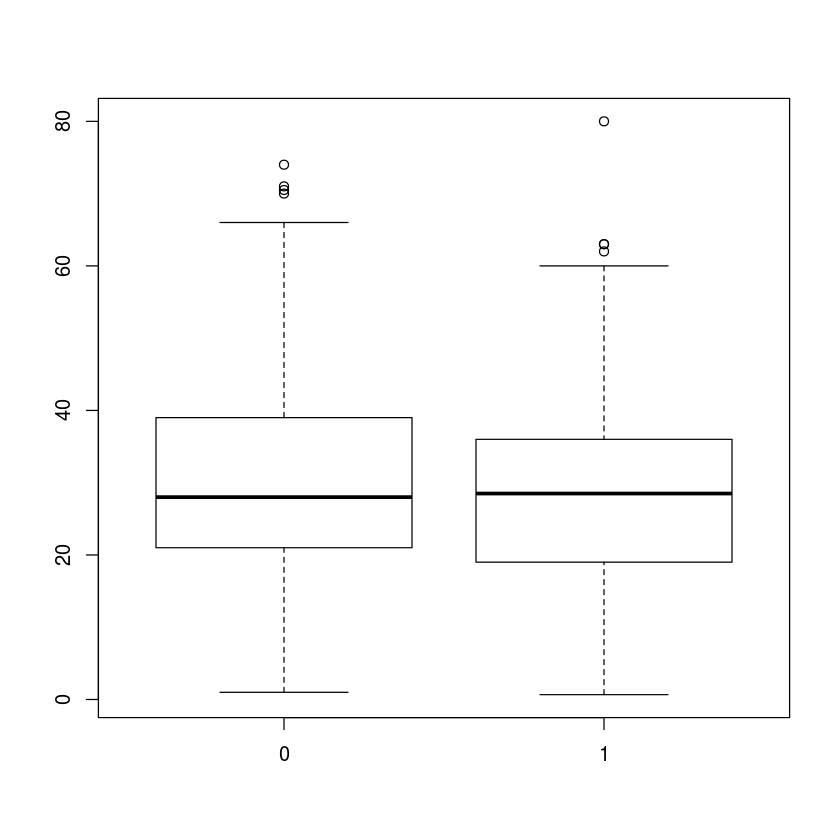

   
    female male
  0     50  287
  1    161   71

        
           1   2   3
  female  71  61  79
  male    77  79 202

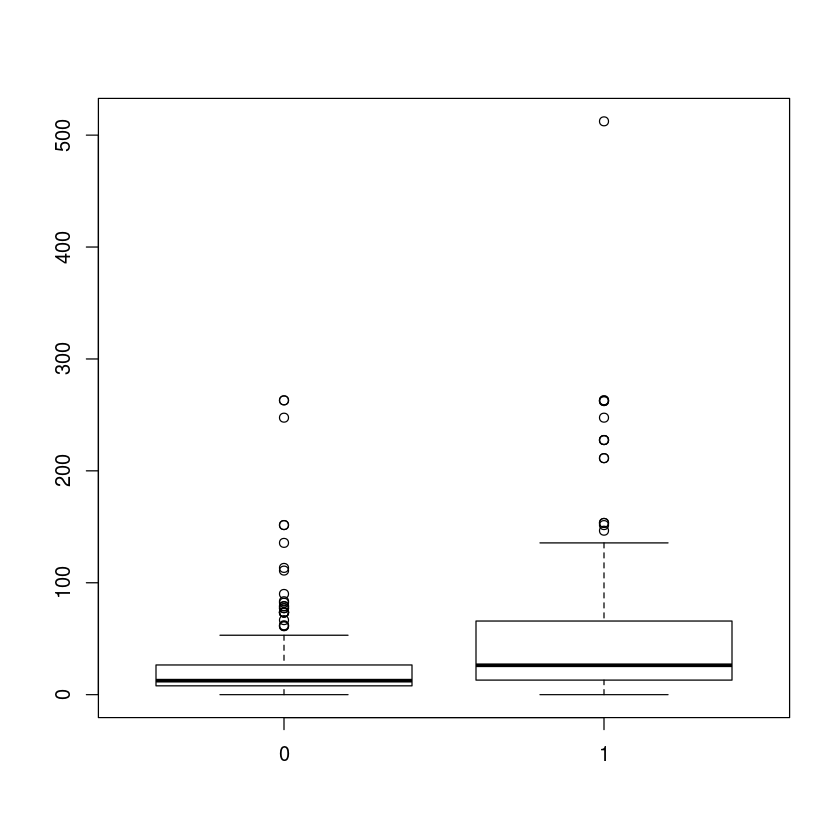

In [5]:
# careful! this is a very rough way to determine which variables are useful to our
# puroposes: no further effort will be made in order to select the best subset of 
# variables, since it is not the goal of this example

# passenger class (categorical)
table(trainSet$Survived,trainSet$Pclass)/nrow(trainSet) #it might be an interesting predictor

# age (numerical)
summary(trainSet$Age) 
boxplot(trainSet$Age~trainSet$Survived) #probably not a good predictor

# fare (numerical)
summary(trainSet$Fare) #no NAs
boxplot(trainSet$Fare~trainSet$Survived) #it may be an interesting predictor

# sex (categorical)
table(trainSet$Survived,trainSet$Sex) 
# it may be an interesting predictor, but it could be associated with the passenger class

table(trainSet$Sex,trainSet$Pclass)
# it could be worth inspecting the relationships among the variables

### Train and test a decision tree with "rpart" package

n= 569 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

 1) root 569 232 0 (0.59226714 0.40773286)  
   2) Sex=male 358  71 0 (0.80167598 0.19832402) *
   3) Sex=female 211  50 1 (0.23696682 0.76303318)  
     6) Pclass=3 79  38 0 (0.51898734 0.48101266)  
      12) Fare>=20.8 19   3 0 (0.84210526 0.15789474) *
      13) Fare< 20.8 60  25 1 (0.41666667 0.58333333)  
        26) Age>=27.5 20   8 0 (0.60000000 0.40000000) *
        27) Age< 27.5 40  13 1 (0.32500000 0.67500000) *
     7) Pclass=1,2 132   9 1 (0.06818182 0.93181818) *

Call:
rpart(formula = Survived ~ Pclass + Sex + Age + SibSp + Embarked + 
    Parch + Fare, data = trainSet)
  n= 569 

          CP nsplit rel error    xerror       xstd
1 0.47844828      0 1.0000000 1.0000000 0.05052599
2 0.02801724      1 0.5215517 0.5215517 0.04207146
3 0.01724138      3 0.4655172 0.4913793 0.04115419
4 0.01000000      4 0.4482759 0.4913793 0.04115419

Variable importance
     Sex     Fare   Pclass    Parch      Age Embarked    SibSp 
      53       15       13       10        5        2        2 

Node number 1: 569 observations,    complexity param=0.4784483
  predicted class=0  expected loss=0.4077329  P(node) =1
    class counts:   337   232
   probabilities: 0.592 0.408 
  left son=2 (358 obs) right son=3 (211 obs)
  Primary splits:
      Sex      splits as  RL,           improve=84.670640, (0 missing)
      Pclass   splits as  RRL,          improve=31.824630, (0 missing)
      Fare     < 52.2771  to the left,  improve=28.289550, (0 missing)
      Embarked spl

[1] "call"                "control"             "cptable"            
 [4] "csplit"              "frame"               "functions"          
 [7] "method"              "numresp"             "ordered"            
[10] "parms"               "splits"              "terms"              
[13] "variable.importance" "where"               "y"

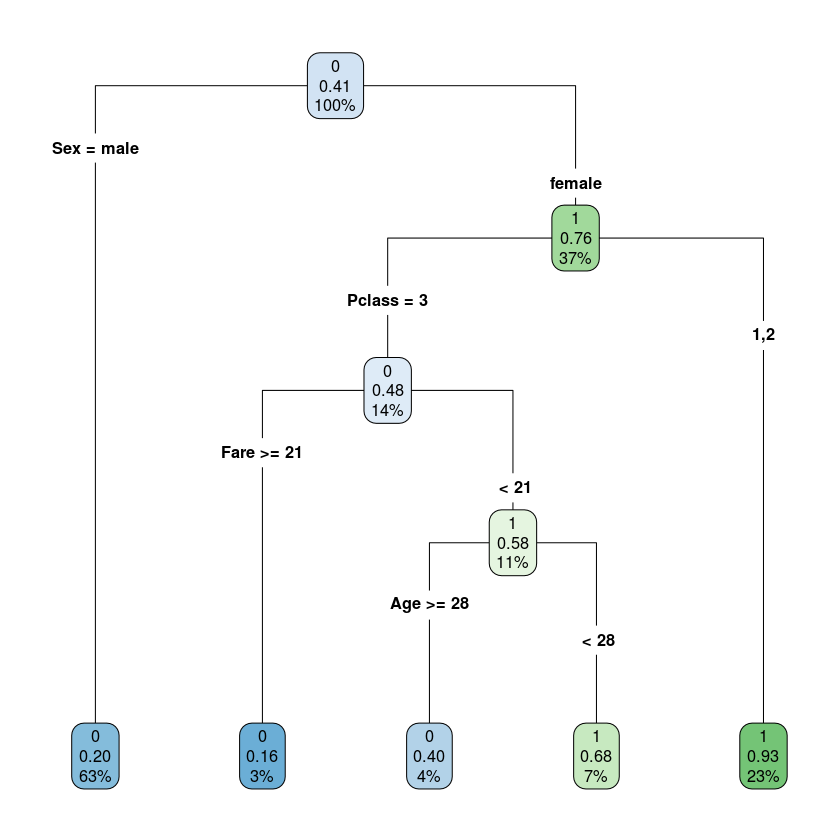

ERROR: Error in eval(expr, envir, enclos): could not find function "confusionMatrix"


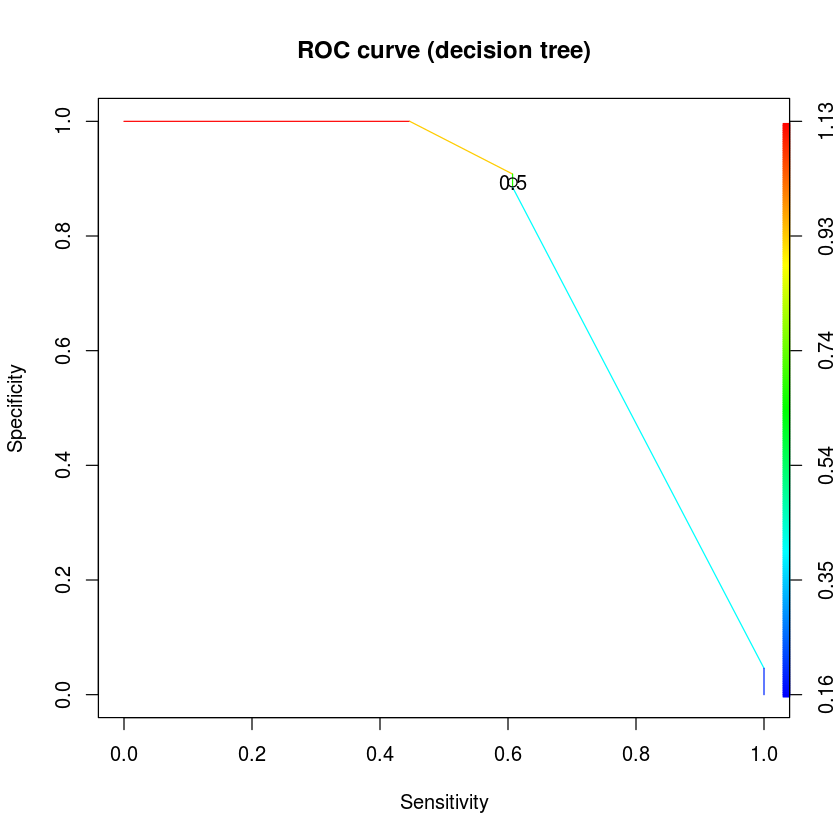

In [6]:
##########################################################################################
##########  ###########################
##########################################################################################
# important feature: complexity parameter (cp) of the tree

# fit the model
dt=rpart(Survived~Pclass+Sex+Age+SibSp+Embarked+Parch+Fare,data=trainSet)
dt
summary(dt)
ls(dt)

# plot the tree
rpart.plot(dt,type=4)

# predict the class of the new obs
dt_pred=predict(dt,newdata=testSet)

# ROC curve
pred=prediction(predictions=dt_pred[,2],labels=testSet$Survived,label.ordering=c("0","1"))
perf=performance(pred,"spec","sens")
plot(perf,print.cutoffs.at=c(0.5),colorize=T,main="ROC curve (decision tree)")
rm(perf,pred)

# confusion table
dt_pred=as.factor(apply(dt_pred,1,which.max)-1)
confusionMatrix(dt_pred,testSet$Survived, positive="1")
# accuracy = (# correctly predicted)/(# of observations)
# sensitivity = (# true positives)/(# real positives)
# specificity = (# true negatives)/(# real negatives)
# detection rate = (# true positives)/(# of observations)
# positive prediction value = (# true positives)/(# predicted positives)
# negative prediction value = (# true negatives)/(# predicted negatives)
# kappa = adjusts accuracy by accounting for the possibility of a correct prediction by chance alone
# range of kappa: -1,1

### Train and test a randomForest model with "randomForest" package

In [ ]:
##########################################################################################
##########   ##############
##########################################################################################
# important features:
# mtry -> Number of variables randomly sampled as candidates at each split
# ntree -> Number of trees to grow: every input row must be predicted at least a few times.
# let's assume that this algorithm works as a "black box"!

# fit the model
rf1=randomForest(Survived~Pclass+Sex+Age+SibSp+Embarked+Parch+Fare,data=trainSet,ntree=500)
rf1
ls(rf1) 

# visualize a single tree grown by the randomForest algorithm
#getTree(rf1,k=1,labelVar=T)
table(is.na(getTree(rf1,k=1,labelVar=T)$pred))
# in this tree only 127 obs have been used and only 63 obs have ben classified

# predict new obs and confusion table
rf1_pred=predict(rf1,newdata=testSet)
confusionMatrix(rf1_pred,testSet$Survived, positive="1")

### Train and test a randomForest model with CARET

In [ ]:
# fit the model (with parallelization over the CV step)
begin=Sys.time()
rf2_caret=train(Survived~Pclass+Sex+Age+SibSp+Embarked+Parch+Fare, #model formula
              data=trainSet,
              method="rf", #method=randomForest
              trControl=trainControl(method = "cv",number=20)) #cross-validation
end=Sys.time()
print(end-begin)
rm(end,begin)

# NB: CV (cross-validation) evaluates the performance of a model using only the training data
# Caret itself does this!!
# workfolow:
# 1) split the training data into (k) equally sized pieces called folds
# 2) train the model on (k-1)/k folds, and check its accuracy on the k-th fold
# 3) repeat this process with each split of the data
# 4) at the end, the percentage accuracy across the different splits of the data is averaged




# view the estimated model
rf2_caret
ls(rf2_caret)
rf2_caret$bestTune
rf2_caret$coef
rf2_caret$finalModel

# predict new obs and confusion table
rf2_pred=predict(rf2_caret,newdata=testSet)
confusionMatrix(rf2_pred,testSet$Survived, positive="1")

### Train and test a logistic model

In [ ]:
# number of covariate pattern
dim(trainSet[,-1])
dim(unique(trainSet[,-1]))
# some rows are duplicated!

# fit the model 
Survived=trainSet$Survived=="1"
log1=glm(cbind(Survived,1-Survived)~Pclass+Sex+Age+SibSp+Embarked+Parch+Fare, family=binomial,data=trainSet[,-1])

# view the estimated model (we won't consider the diagnostics of the model)
summary(log1) # Pclass, Sex and Age have significant coefficients
ls(log1)

# predict new obs and confusion table
log1_pred=round(predict(log1,newdata=testSet,type="response"))
confusionMatrix(log1_pred,testSet$Survived, positive="1")

# ROC curve
pred=prediction(predictions=predict(log1,newdata=testSet,type="response"),labels=testSet$Survived,label.ordering=c("0","1"))
perf=performance(pred,"spec","sens")
plot(perf,print.cutoffs.at=c(0.5),colorize=T,main="ROC curve (decision tree)")
rm(perf,pred,Survived) 

### Train and test a logistic model with CARET

In [ ]:
# fit the model (with parallelization over the CV step)
begin=Sys.time()
log2_caret=train(Survived~Pclass+Sex+Age+SibSp+Embarked+Parch+Fare, #model formula
                data=trainSet,
                method="glm",
                trControl=trainControl(method = "cv",number=20)) #cross-validation
end=Sys.time()
print(end-begin)
rm(end,begin)


# view the estimated model
summary(log2_caret) # Pclass, Sex and Age have significant coefficients
ls(log2_caret)
log2_caret$finalModel


# predict new obs and confusion table
log2_pred=predict(log2_caret,newdata=testSet)
confusionMatrix(log2_pred,testSet$Survived, positive="1")